In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import pickle
import re
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy.stats import shapiro 
from scipy.stats import kstest
import EntropyHub as EH
from scipy import interpolate
import math
import nolds
from scipy import signal

### sample entropy (self)

In [18]:
def maxdist(vector_a,vector_b):
    return np.max([np.abs(vector_a-vector_b)])
def B_m(Matrix,m,r):
    length=np.shape(Matrix)[0]-m+1
    Matrix_window_list=[Matrix[i:i+m] for i in range(length)]
    D = np.zeros((length-1, length-1))
    for i in range(length-1):
        for j in range(i+1,length-1):
            if maxdist(Matrix_window_list[i],Matrix_window_list[j])<r:
                D[i,j]=1
                D[j,i]=D[i,j]
    count=np.sum(D)
    return count/((length-2)*(length-1))
    
def A_m(Matrix,m,r):
    length=np.shape(Matrix)[0]-m
    Matrix_window_list=[Matrix[i:i+m+1] for i in range(length)]
    D = np.zeros((length, length))
    for i in range(length):
        for j in range(i+1,length):
            if maxdist(Matrix_window_list[i],Matrix_window_list[j])<r:
                D[i,j]=1
                D[j,i]=D[i,j]
    count=np.sum(D)
    return count/((length-1)*length)
def SampEn_self(Matrix,m,r):
    r_std=np.std(Matrix)*r
    return -np.log(A_m(Matrix,m,r_std)/B_m(Matrix,m,r_std))

### generate sine wave data

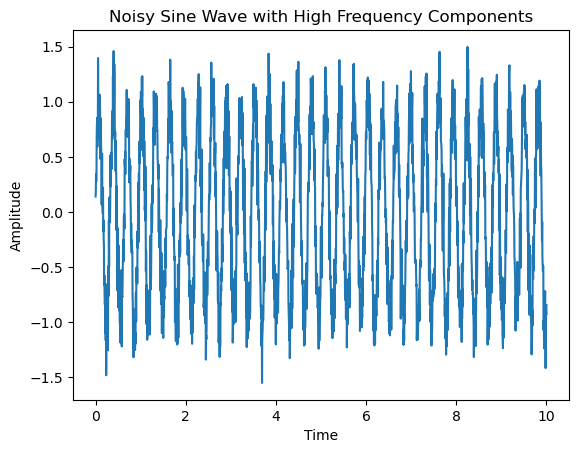

In [3]:
t = np.linspace(0, 10, 2000)
data_sine = np.sin(20 * t) + np.random.normal(0, 0.2, size=2000)
# Plot the time series
plt.plot(t, data_sine)
plt.title("Noisy Sine Wave with High Frequency Components")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [7]:
# Print the sample entropy value
m=2
r=0.2* np.std(data_sine)
sampen_nolds=nolds.sampen(data_sine, emb_dim=m, tolerance=r)
print("Sample Entropy from nolds:", sampen_nolds)
sampen_self=SampEn_self(data_sine,m,0.2)
print("Sample Entropy by myself:", sampen_self)

Sample Entropy from nolds: 1.1737037648574766
Sample Entropy by myself: 1.1737037648574766


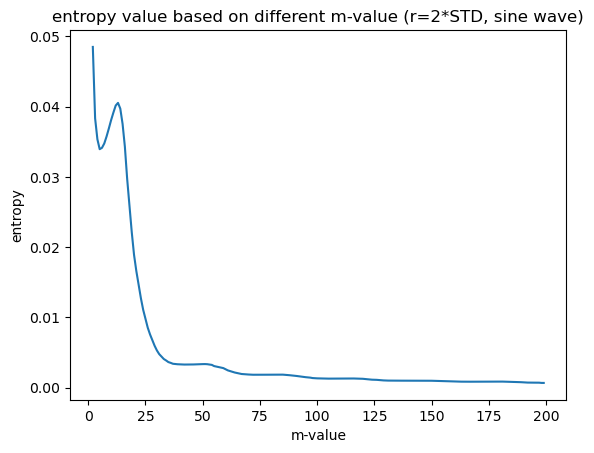

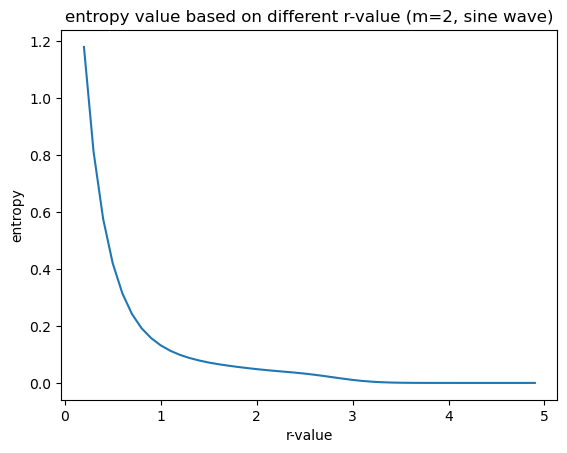

In [29]:
en_mlist_2_200=[]
mlist_2_200=[]
en_rlist_02_5=[]
rlist_02_5=[]
for m in range(2,200):
    r=2* np.std(data_sine)
    en=nolds.sampen(data_sine, emb_dim=m, tolerance=r)
    if not math.isinf(en):
        en_mlist_2_200.append(en)
        mlist_2_200.append(m)
for r in range(2,50):
    m=2
    std=np.std(data_sine)
    en=nolds.sampen(data_sine, emb_dim=m, tolerance=r*std*0.1)
    if not math.isinf(en):
        en_rlist_02_5.append(en)
        rlist_02_5.append(r*0.1)
plt.plot(mlist_2_200, en_mlist_2_200)
plt.title("entropy value based on different m-value (r=2*STD, sine wave)")
plt.xlabel("m-value")
plt.ylabel("entropy")
plt.show()
plt.plot(rlist_02_5, en_rlist_02_5)
plt.title("entropy value based on different r-value (m=2, sine wave)")
plt.xlabel("r-value")
plt.ylabel("entropy")
plt.show()

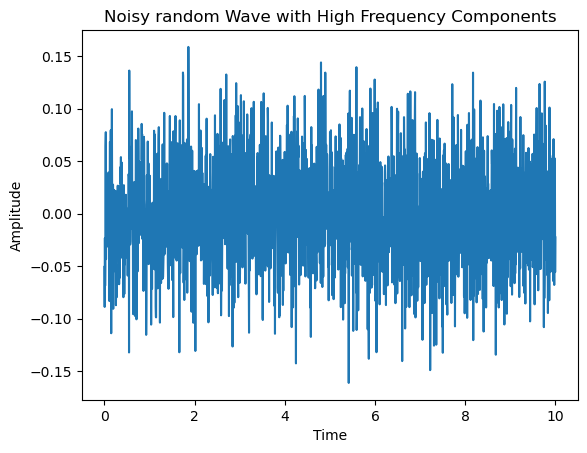

In [8]:
t = np.linspace(0, 10, 2000)
data_random = np.random.normal(0, 0.05, size=2000)
# Plot the time series
plt.plot(t, data_random)
plt.title("Noisy random Wave with High Frequency Components")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

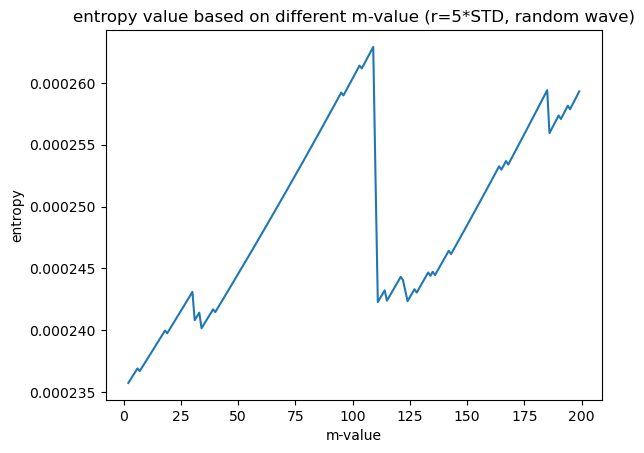

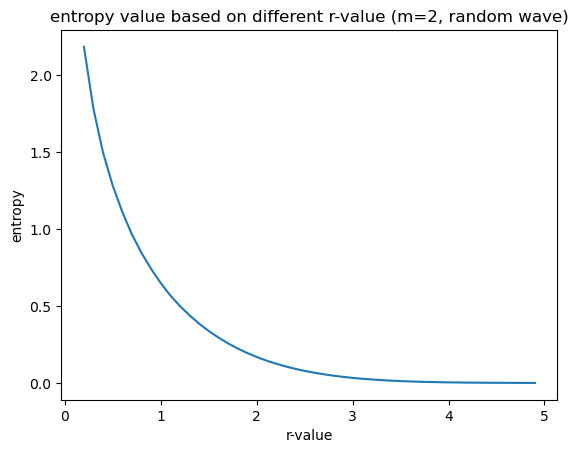

In [9]:
en_mlist=[]
mlist=[]
en_rlist=[]
rlist=[]
std=np.std(data_random)
for m in range(2,200):
    r=5* std
    en=nolds.sampen(data_random, emb_dim=m, tolerance=r)
    if not math.isinf(en):
        en_mlist.append(en)
        mlist.append(m)
for r in range(2,50):
    m=2
    en=nolds.sampen(data_random, emb_dim=m, tolerance=r*std*0.1)
    if not math.isinf(en):
        en_rlist.append(en)
        rlist.append(r*0.1)
plt.plot(mlist, en_mlist)
plt.title("entropy value based on different m-value (r=5*STD, random wave)")
plt.xlabel("m-value")
plt.ylabel("entropy")
plt.show()
plt.plot(rlist, en_rlist)
plt.title("entropy value based on different r-value (m=2, random wave)")
plt.xlabel("r-value")
plt.ylabel("entropy")
plt.show()

### pain data

In [4]:
class pain_monitering_D1:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D1_time=[]
        self.D1_prediction=-1
        self.D1_confidence=-1
    def __str__(self):
        print("participant: "+self.PID)
        print("Day 1 rating: "+str(len(self.D1_rating))+" sessions")
        print("Day 1 timing: "+str(len(self.D1_time))+" sessions")
        print("Day 1 prediction: "+ str(self.D1_prediction))
        print("Day 1 confidence: "+ str(self.D1_confidence))
        return ""
    def update_rating_time(self,rating,time):
        self.D1_rating=rating
        self.D1_time=time
    def update_prediction_confidence(self,pred,conf):
        self.D1_prediction=pred
        self.D1_confidence=conf

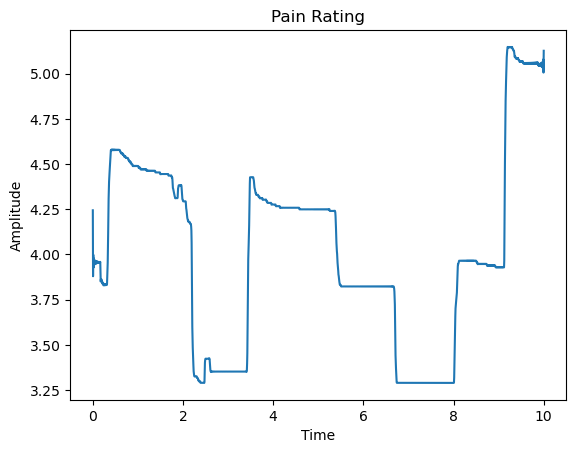

In [5]:
Day1_list=pd.read_pickle('../data/dataset/D1_data_downsample.pkl')["Day1_part_downsample_list"]
# data_pain_1 = Day1_list[0].D1_rating[0]
# t=Day1_list[0].D1_time[0]
data_pain_1 = signal.resample(Day1_list[0].D1_rating[0],2000)
t = np.linspace(0, 10, 2000)
# Plot the time series
plt.plot(t, data_pain_1)
plt.title("Pain Rating")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

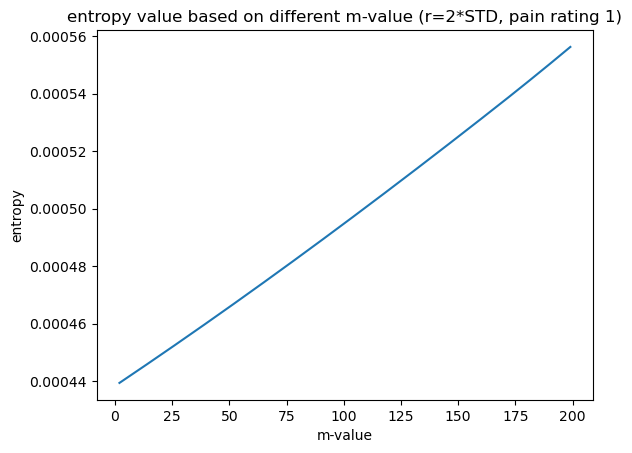

In [42]:
en_mlist=[]
mlist=[]
# en_rlist=[]
# rlist=[]
std=np.std(data_pain_1)
for m in range(2,200):
    r=3* std
    en=nolds.sampen(data_pain_1, emb_dim=m, tolerance=r)
    if not math.isinf(en):
        en_mlist.append(en)
        mlist.append(m)
# for r in range(2,50):
#     m=200
#     en=nolds.sampen(data_pain_1, emb_dim=m, tolerance=r*std*0.1)
#     if not math.isinf(en):
#         en_rlist.append(en)
#         rlist.append(r*0.1)
plt.plot(mlist, en_mlist)
plt.title("entropy value based on different m-value (r=2*STD, pain rating 1)")
plt.xlabel("m-value")
plt.ylabel("entropy")
plt.show()
# plt.plot(rlist, en_rlist)
# plt.title("entropy value based on different r-value (m=200, pain rating 1)")
# plt.xlabel("r-value")
# plt.ylabel("entropy")
# plt.show()

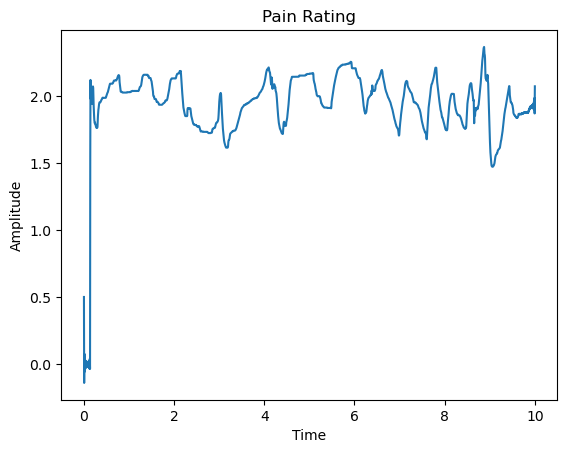

In [10]:
data_pain_2 = signal.resample(Day1_list[30].D1_rating[0],2000)
t = np.linspace(0, 10, 2000)
# Plot the time series
plt.plot(t, data_pain_2)
plt.title("Pain Rating")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

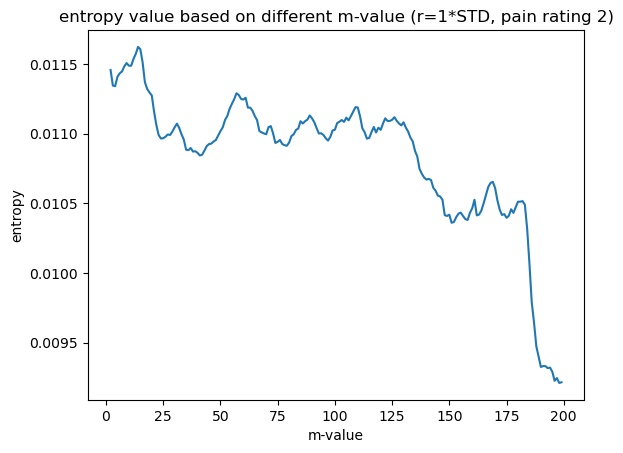

In [16]:
en_mlist=[]
mlist=[]
# en_rlist=[]
# rlist=[]
std=np.std(data_pain_2)
for m in range(2,200):
    r=1* std
    en=nolds.sampen(data_pain_2, emb_dim=m, tolerance=r)
    if not math.isinf(en):
        en_mlist.append(en)
        mlist.append(m)
# for r in range(2,50):
#     m=2
#     en=nolds.sampen(data_pain_2, emb_dim=m, tolerance=r*std*0.1)
#     if not math.isinf(en):
#         en_rlist.append(en)
#         rlist.append(r*0.1)
plt.plot(mlist, en_mlist)
plt.title("entropy value based on different m-value (r=1*STD, pain rating 2)")
plt.xlabel("m-value")
plt.ylabel("entropy")
plt.show()
# plt.plot(rlist, en_rlist)
# plt.title("entropy value based on different r-value (m=2, pain rating 1)")
# plt.xlabel("r-value")
# plt.ylabel("entropy")
# plt.show()

## multiscale entropy

In [78]:
def generate_Coarse_grained(data,scale):
    averages = []
    for i in range(0, len(data)-scale+1, scale):
        average = sum(data[i:i+scale]) / scale
        averages.append(average)
    if len(data)%scale!=0:
        averages.extend(data[-1*(len(data)%scale):])
    return averages
def MSEn(data,scale,m,r):
    MSdata=generate_Coarse_grained(data,scale)
    r=r*np.std(MSdata)
    m=m//scale
    return nolds.sampen(MSdata, emb_dim=m, tolerance=r)

In [79]:
scales=[1,2,3,4,5]
MSEn_list=[]
for scale in scales:
    MSEn_list.append(MSEn(data_pain_1,scale,200,0.5))
print(MSEn_list)

[0.01519805023918517, 0.030702242342320184, 0.045933699480217714, 0.06230737703614033, 0.07715706487070653]
